In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

import torch
import evaluate
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import numpy as np
import pandas as pd
import os

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## <b>VQVAE Experiments<b>      

In [3]:
### Load data ###
results_dir = '/home/carolinechoi/3d-recon/outputs/2021-05-29/17-30-11/results'

embed = torch.load(os.path.join(results_dir, 'embed.pt'))
encoding_inds_img = torch.load(os.path.join(results_dir, 'encoding_inds.pt'))
RT = torch.load(os.path.join(results_dir, 'RT.pt'))
K = torch.load(os.path.join(results_dir, 'K.pt'))

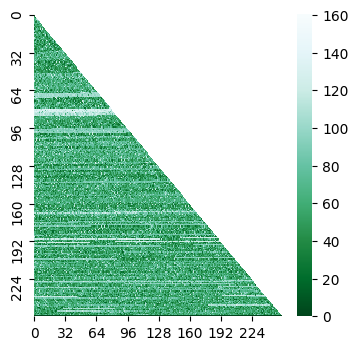

<Figure size 432x288 with 0 Axes>

In [4]:
### Plot latents pairwise distance heatmap ###

def plot_heatmap(embed, results_dir):
    pairwise_dist = F.pdist(embed.t(), p=2).to(DEVICE)
    N = embed.t().shape[0]
    pairwise_distances = torch.zeros((N, N-1)).to(DEVICE)
    temp = torch.tril_indices(N-1, N).to(DEVICE)
    pairwise_distances[temp[0], temp[1]] = pairwise_dist
    pairwise_distances = pairwise_distances.cpu().numpy()

    plt.figure(0, figsize=(4,4), dpi=100)
    mask = np.triu(np.ones_like(pairwise_distances, dtype=bool))
    sns.heatmap(pairwise_distances, cmap="BuGn_r", mask=mask, xticklabels=32, yticklabels=32)
    plt.show()
    
    save_file_fig = os.path.join(results_dir, 'heatmap.png')
    plt.savefig(save_file_fig, bbox_inches="tight")


plot_heatmap(embed, results_dir)

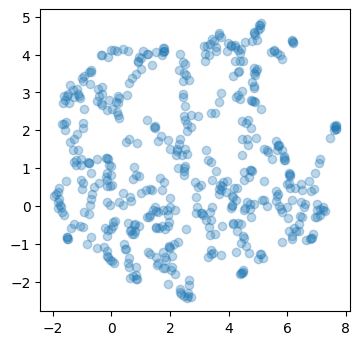

In [5]:
### Plot latent space projected onto 2D ###

def plot_embeddings(embed, results_dir):
    plt.figure(1, figsize=(4, 4), dpi=100)
    proj = umap.UMAP(n_neighbors=5,
                 min_dist=0.1,
                 metric='euclidean').fit_transform(embed.data.cpu().numpy())
    plt.scatter(proj[:,0], proj[:,1], alpha=0.3)
    save_file = os.path.join(results_dir, 'view_embeds.png')
    plt.savefig(save_file, bbox_inches="tight")


plot_embeddings(embed, results_dir)

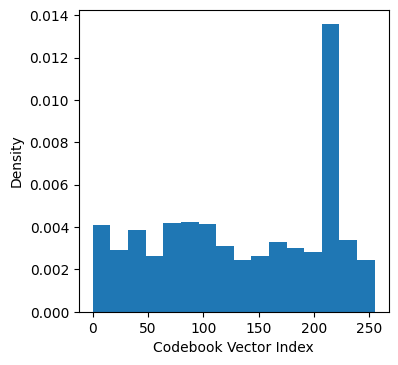

In [6]:
#### Plot latent vector frequency of all input images ###

def plot_latents_freq(encoding_inds):
    plt.figure(2, figsize=(4, 4), dpi=100)
    plt.hist(encoding_inds.cpu().numpy(), bins=16, density=True)
    plt.xlabel('Codebook Vector Index')
    plt.ylabel('Density')
    save_file = os.path.join(results_dir, 'latents_freq.png')
    plt.savefig(save_file, bbox_inches="tight")

N, H, W = encoding_inds_img.shape
plot_latents_freq(encoding_inds_img.reshape(N*H*W))

In [7]:
### POINT CLOUD RENDERING ###
import utils
def render_ptcld(ptcld, P, save_file):
    '''
    Renders a single 3D point cloud.

    Inputs:
        ptcld: Tensor of shape (N, S, 3)
        P: rotation matrix
        save_file: file to save render to
    
    Returns:
        ptcld_img: 2D rendered image of 3D point cloud in camera coordinates
    '''

    ptcld_rot = utils.rotate_verts(P, ptcld)
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(ptcld_rot[..., 0].cpu(), ptcld_rot[..., 2].cpu(), ptcld_rot[..., 1].cpu(), s=1)
    ax.view_init(elev=0, azim=270)
    ax.grid(False)

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(-0.5, 0.5)
    ax.axis('off')

    plt.savefig(save_file, bbox_inches="tight")

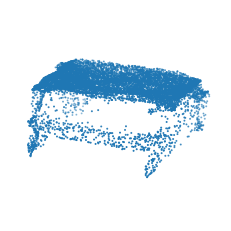

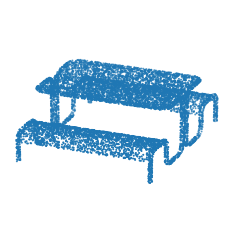

In [16]:
### Render point clouds generated from images ###

ptcld = torch.load(os.path.join(results_dir, 'ptcld_02828884-f60378083ea9b7fa5e14e00a99d44acb-00_0.pt'))[:1]
save_file1 = os.path.join(results_dir, 'ptcld_02828884-f60378083ea9b7fa5e14e00a99d44acb-00_0.png')
ptcld_gt = torch.load(os.path.join(results_dir, 'ptcld_gt_02828884-f60378083ea9b7fa5e14e00a99d44acb-00_0.pt'))[:1]
save_file2 = os.path.join(results_dir, 'ptcld_gt_02828884-f60378083ea9b7fa5e14e00a99d44acb-00_0.png')

render_ptcld(ptcld, K[:1], save_file1)
render_ptcld(ptcld_gt, K[:1], save_file2)

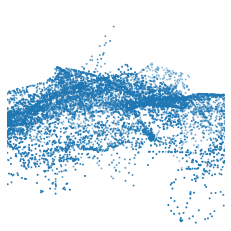

In [9]:
### Render point clouds generated from sampled latents ###

samples_dir = '/home/carolinechoi/3d-recon/outputs/2021-05-29/17-30-11/samples'
ptcld_sample = torch.load(os.path.join(samples_dir, 'ptclds_2021-06-02.03-37-29.pt'))[:1]
render_ptcld(ptcld_sample, K[:1], os.path.join(samples_dir, 'ptclds_2021-06-02.03-37-29.png'))

## <b>VAE Experiments<b>

In [10]:
results_dir = '/home/carolinechoi/3d-recon/outputs/2021-05-31/17-28-11/results'
samples_dir = '/home/carolinechoi/3d-recon/outputs/2021-05-31/17-28-11/samples'

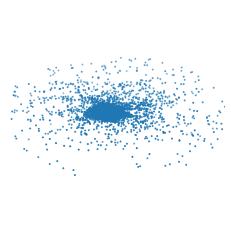

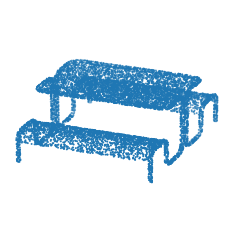

In [11]:
### Render point clouds generated from images ###

ptcld = torch.load(os.path.join(results_dir, 'ptcld_02828884-f60378083ea9b7fa5e14e00a99d44acb-00_0.pt'))[:1]
save_file1 = os.path.join(results_dir, 'ptcld_02828884-f60378083ea9b7fa5e14e00a99d44acb-00_0.png')
ptcld_gt = torch.load(os.path.join(results_dir, 'ptcld_gt_02828884-f60378083ea9b7fa5e14e00a99d44acb-00_0.pt'))[:1]
save_file2 = os.path.join(results_dir, 'ptcld_gt_02828884-f60378083ea9b7fa5e14e00a99d44acb-00_0.pt.png')

render_ptcld(ptcld, K[:1], save_file1)
render_ptcld(ptcld_gt, K[:1], save_file2)

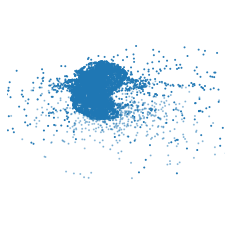

In [12]:
### Render point clouds generated from sampled latents ###

ptcld_sample = torch.load(os.path.join(samples_dir, 'ptclds_2021-06-02.03-34-16.pt'))[:1]
render_ptcld(ptcld_sample, K[:1], os.path.join(results_dir, 'sampled_ptclds_2021-06-02.03-34-16.png'))

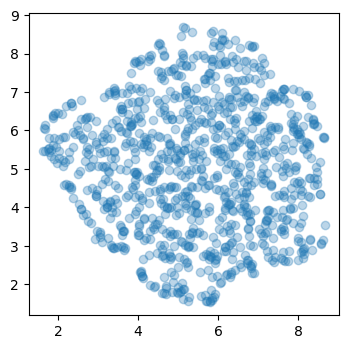

In [13]:
### Plot latent space projected onto 2D ###

embed = torch.load(os.path.join(samples_dir, 'vae_latents_2021-06-02.03-34-16.pt'))
plot_embeddings(embed, results_dir)

## <b>AE Experiments<b>

In [14]:
results_dir = '/home/carolinechoi/3d-recon/outputs/2021-05-29/23-34-32/results'

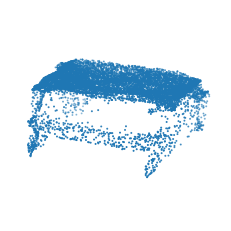

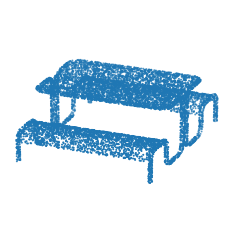

In [15]:
### Render point clouds generated from images ###

ptcld = torch.load(os.path.join(results_dir, 'ptcld_02828884-f60378083ea9b7fa5e14e00a99d44acb-00_0.pt'))[:1]
save_file1 = os.path.join(results_dir, 'ptcld_02828884-f60378083ea9b7fa5e14e00a99d44acb-00_0.png')
ptcld_gt = torch.load(os.path.join(results_dir, 'ptcld_gt_02828884-f60378083ea9b7fa5e14e00a99d44acb-00_0.pt'))[:1]
save_file2 = os.path.join(results_dir, 'ptcld_gt_02828884-f60378083ea9b7fa5e14e00a99d44acb-00_0.png')

render_ptcld(ptcld, K[:1], save_file1)
render_ptcld(ptcld_gt, K[:1], save_file2)